In [0]:
from fastai import *
from fastai.tabular import *
import pandas as pd
from torchsummary import summary
import torch
from torch import nn
import imageio
import torch
import glob
from fastai.vision import *
import os
from torch import nn
import torch.nn.functional as F

In [2]:
from google.colab import drive
drive.mount('/content/drive', force_remount = True)
%cd "/content/drive/My Drive/automatic-asset-classification"
%ls "/content/drive/My Drive/automatic-asset-classification"

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive
/content/drive/My Drive/automatic-asset-classification
data/  models/


# Data

In [0]:
np.random.seed(3333)
torch.manual_seed(3333)

image_path = "/content/drive/My Drive/automatic-asset-classification/data/final_dataset"
size = 224
batchsize = 32
tfms = get_transforms(do_flip = True)
src = (ImageImageList.from_folder(image_path).split_by_rand_pct(seed=2).label_from_func(lambda x: x))
data = (src.transform(tfms, size=size, tfm_y=True)
        .databunch(bs=batchsize)
        .normalize(imagenet_stats, do_y = False))

# Models

## Stacked Models

In [16]:
class AutoEncoder(nn.Module):
    def __init__(self):
        super(AutoEncoder, self).__init__()

        resnet = torch.hub.load('pytorch/vision:v0.5.0', 'resnet34', pretrained = True)
        resnet = nn.Sequential(*(list(resnet.children())[0:3]))
        for param in resnet.parameters():
            param.requires_grad = False

        self.encoder = nn.Sequential(resnet)

        self.decoder = nn.Sequential( 
            nn.Upsample(scale_factor = 2, mode = 'bilinear'),
            nn.Conv2d(64, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False),
            nn.ReLU(inplace=True)
        )

    def encode(self, x): return self.encoder(x)

    def decode(self,x): return torch.clamp(self.decoder(x), min = 0, max=1)

      
    def forward(self, x):
      encoded = self.encoder(x)
      decoded = self.decoder(encoded)
      return torch.clamp(decoded, min = 0, max = 1)

class AutoEncoder2(nn.Module):
    def __init__(self):
        super(AutoEncoder2, self).__init__()

        resnet = torch.hub.load('pytorch/vision:v0.5.0', 'resnet34', pretrained = True)
        resnet = nn.Sequential(*(list(resnet.children())[3:5]))
        for param in resnet.parameters():
            param.requires_grad = False
        for i in range(len(resnet)):
            for param in resnet[1][i].bn1.parameters():
                param.requires_grad = True
            for param in resnet[1][i].bn2.parameters():
                param.requires_grad = True

        self.encoder = nn.Sequential(resnet)

        self.decoder = nn.Sequential( 
            nn.Upsample(scale_factor = 2, mode = 'bilinear'),
            nn.Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False),
            nn.ReLU(inplace=True)
        )

    def encode(self,x): return self.encoder(x)

    def decode(self,x): return self.decoder(x)

      
    def forward(self, x):
      encoded = self.encoder(x)
      decoded = self.decoder(encoded)
      return decoded

class AutoEncoder3(nn.Module):
    def __init__(self):
        super(AutoEncoder3, self).__init__()

        resnet = torch.hub.load('pytorch/vision:v0.5.0', 'resnet34', pretrained = True)
        resnet = nn.Sequential(*(list(resnet.children())[5]))
        for param in resnet.parameters():
            param.requires_grad = False
        for i in range(len(resnet)):
            for param in resnet[i].bn1.parameters():
                param.requires_grad = True
            if i== 0:
                for param in resnet[i].downsample[1].parameters():
                  param.requires_grad = True
            for param in resnet[i].bn2.parameters():
                param.requires_grad = True

        self.encoder = nn.Sequential(resnet)

        self.decoder = nn.Sequential( 
            nn.Upsample(scale_factor = 2, mode = 'bilinear'),
            nn.Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False),
            nn.BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False),
            nn.BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU(inplace=True)
        )

    def encode(self,x): return self.encoder(x)

    def decode(self,x): return self.decoder(x)

      
    def forward(self, x):
      encoded = self.encoder(x)
      decoded = self.decoder(encoded)
      return decoded

class AutoEncoder4(nn.Module):
    def __init__(self):
        super(AutoEncoder4, self).__init__()

        resnet = torch.hub.load('pytorch/vision:v0.5.0', 'resnet34', pretrained = True)
        resnet = nn.Sequential(*(list(resnet.children())[6]))
        for param in resnet.parameters():
            param.requires_grad = False
        for i in range(len(resnet)):
            for param in resnet[i].bn1.parameters():
                param.requires_grad = True
            if i== 0:
                for param in resnet[i].downsample[1].parameters():
                  param.requires_grad = True
            for param in resnet[i].bn2.parameters():
                param.requires_grad = True

        self.encoder = nn.Sequential(resnet)

        self.decoder = nn.Sequential( 
            nn.Upsample(scale_factor = 2, mode = 'bilinear'),
            nn.Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False),
            nn.BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False),
            nn.BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU(inplace=True)
        )

    def encode(self,x): return self.encoder(x)

    def decode(self,x): return self.decoder(x)

      
    def forward(self, x):
      encoded = self.encoder(x)
      decoded = self.decoder(encoded)
      return decoded

class AutoEncoder5(nn.Module):
    def __init__(self):
        super(AutoEncoder5, self).__init__()

        resnet = torch.hub.load('pytorch/vision:v0.5.0', 'resnet34', pretrained = True)
        resnet = nn.Sequential(*(list(resnet.children())[7]))
        for param in resnet.parameters():
            param.requires_grad = False
        for i in range(len(resnet)):
            for param in resnet[i].bn1.parameters():
                param.requires_grad = True
            if i== 0:
                for param in resnet[i].downsample[1].parameters():
                  param.requires_grad = True
            for param in resnet[i].bn2.parameters():
                param.requires_grad = True

        self.encoder = nn.Sequential(resnet)

        self.decoder = nn.Sequential( 
            nn.Upsample(scale_factor = 2, mode = 'bilinear'),
            nn.Conv2d(512, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False),
            nn.BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False),
            nn.BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU(inplace=True)
        )

    def encode(self,x): return self.encoder(x)

    def decode(self,x): return self.decoder(x)

      
    def forward(self, x):
      encoded = self.encoder(x)
      decoded = self.decoder(encoded)
      return decoded

class AdaptiveConcatPool2d(Module):
    "Layer that concats `AdaptiveAvgPool2d` and `AdaptiveMaxPool2d`."
    def __init__(self, sz:Optional[int]=None):
        "Output will be 2*sz or 2 if sz is None"
        self.output_size = sz or 1
        self.ap = nn.AdaptiveAvgPool2d(self.output_size)
        self.mp = nn.AdaptiveMaxPool2d(self.output_size)

    def forward(self, x): return torch.cat([self.mp(x), self.ap(x)], 1)


class ArrayDataset(Dataset):
    "Sample numpy array dataset"
    def __init__(self, x, y):
        self.x, self.y = x, y
        self.c = 2 # binary label
    
    def __len__(self):
        return len(self.x)
    
    def __getitem__(self, i):
        return self.x[i], self.y[i]

class AutoEncoder6(nn.Module):
    def __init__(self):
        super(AutoEncoder6, self).__init__()

        

        self.encoder = nn.Sequential(AdaptiveConcatPool2d())

        self.decoder = nn.Sequential( 
            nn.Upsample(scale_factor = 2, mode = 'bilinear'),
            nn.Conv2d(1024, 1024, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False),
            nn.BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU(inplace=True),
            nn.Upsample(scale_factor = 3.5, mode = 'bilinear'),
            nn.Conv2d(1024, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False),
            nn.BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU(inplace=True)
        )

    def encode(self,x): return self.encoder(x)

    def decode(self,x): return self.decoder(x)

      
    def forward(self, x):
      encoded = self.encoder(x)
      decoded = self.decoder(encoded)
      return decoded

tens = np.random.rand(32,3,224,224)
tens_x, tens_y = ArrayDataset(tens, tens), ArrayDataset(tens, tens)
tens = DataBunch.create(tens_x, tens_y, bs=32)
autoencoder = AutoEncoder()
learn = Learner(data, autoencoder, loss_func=F.mse_loss);
learn = learn.load('ae_res_1')


tens = np.random.rand(32,64,112,112)
tens_x, tens_y = ArrayDataset(tens, tens), ArrayDataset(tens, tens)
tens = DataBunch.create(tens_x, tens_y, bs=32)
autoencoder2 = AutoEncoder2()
learn2 = Learner(tens, autoencoder2, loss_func=F.mse_loss);
learn2 = learn2.load('ae_res_2')

tens = np.random.rand(32,64,56,56)
tens_x, tens_y = ArrayDataset(tens, tens), ArrayDataset(tens, tens)
tens = DataBunch.create(tens_x, tens_y, bs=32)
autoencoder3 = AutoEncoder3()
learn3 = Learner(tens, autoencoder3, loss_func=F.mse_loss);
learn3 = learn3.load('ae_res_3')

tens = np.random.rand(32,128,28,28)
tens_x, tens_y = ArrayDataset(tens, tens), ArrayDataset(tens, tens)
tens = DataBunch.create(tens_x, tens_y, bs=32)
autoencoder4 = AutoEncoder4()
learn4 = Learner(tens, autoencoder4, loss_func=F.mse_loss);
learn4 = learn4.load('ae_res_4')

tens = np.random.rand(32,256,14,14)
tens_x, tens_y = ArrayDataset(tens, tens), ArrayDataset(tens, tens)
tens = DataBunch.create(tens_x, tens_y, bs=32)
autoencoder5 = AutoEncoder5()
learn5 = Learner(tens, autoencoder5, loss_func=F.mse_loss);
learn5 = learn5.load('ae_res_5')

tens = np.random.rand(32,512,7,7)
tens_x, tens_y = ArrayDataset(tens, tens), ArrayDataset(tens, tens)
tens = DataBunch.create(tens_x, tens_y, bs=32)
autoencoder6 = AutoEncoder6()
learn6 = Learner(tens, autoencoder6, loss_func=F.mse_loss);
learn6 = learn6.load('ae_res_6')


Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.5.0
Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.5.0
Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.5.0
Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.5.0
Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.5.0


In [32]:
torch.save(autoencoder, 'ae_res_1_torch')
torch.save(autoencoder2, 'ae_res_2_torch')
torch.save(autoencoder3, 'ae_res_3_torch')
torch.save(autoencoder4, 'ae_res_4_torch')
torch.save(autoencoder5, 'ae_res_5_torch')
torch.save(autoencoder6, 'ae_res_6_torch')

/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type AutoEncoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type AutoEncoder2. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type AutoEncoder3. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type AutoEncoder4. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/loca

## Full Model

In [34]:
autoencoder

AutoEncoder(
  (encoder): Sequential(
    (0): Sequential(
      (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
  )
  (decoder): Sequential(
    (0): Upsample(scale_factor=2.0, mode=bilinear)
    (1): Conv2d(64, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (2): ReLU(inplace=True)
  )
)

In [0]:
class AdaptiveConcatPool2d(Module):
    "Layer that concats `AdaptiveAvgPool2d` and `AdaptiveMaxPool2d`."
    def __init__(self, sz:Optional[int]=None):
        "Output will be 2*sz or 2 if sz is None"
        self.output_size = sz or 1
        self.ap = nn.AdaptiveAvgPool2d(self.output_size)
        self.mp = nn.AdaptiveMaxPool2d(self.output_size)

    def forward(self, x): return torch.cat([self.mp(x), self.ap(x)], 1)

class FullModels(nn.Module):
    def __init__(self, nums):
        super(FullModels, self).__init__()

        self.nums = nums

        autoencoders = []
        for i in range(1,self.nums + 1):
          autoencoders.append(torch.load('ae_res_'+str(i)+'_torch'))


        self.encoder = nn.Sequential(*[autoencoder.encoder for autoencoder in autoencoders])

        self.decoder = nn.Sequential(*[autoencoder.decoder for autoencoder in reversed(autoencoders)])

    def encode(self,x): return self.encoder(x)

    def decode(self,x): return self.decoder(x)

      
    def forward(self, x):
      encoded = self.encoder(x)
      decoded = self.decoder(encoded)
      return decoded

In [0]:
test_model = FullModels(6)
test_1 = Learner(data, test_model, loss_func=F.mse_loss)

In [45]:
test_1.summary()

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2506: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


FullModels
Layer (type)         Output Shape         Param #    Trainable 
Conv2d               [64, 112, 112]       9,408      False     
______________________________________________________________________
BatchNorm2d          [64, 112, 112]       128        False     
______________________________________________________________________
ReLU                 [64, 112, 112]       0          False     
______________________________________________________________________
MaxPool2d            [64, 56, 56]         0          False     
______________________________________________________________________
Conv2d               [64, 56, 56]         36,864     False     
______________________________________________________________________
BatchNorm2d          [64, 56, 56]         128        True      
______________________________________________________________________
ReLU                 [64, 56, 56]         0          False     
___________________________________________________

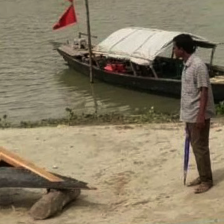

In [53]:
data.train_ds[0][0]

In [61]:
test_1.fit_one_cycle(1)

epoch,train_loss,valid_loss,time
0,0.069946,0.053000,02:24


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2506: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


In [62]:
test_1.lr_find()

epoch,train_loss,valid_loss,time
0,0.063087,#na#,00:17
1,0.061653,#na#,00:17
2,0.058687,#na#,00:16
3,0.053621,#na#,00:16
4,0.063412,#na#,00:16
5,0.061818,#na#,00:16


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2506: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


Min numerical gradient: 1.91E-04
Min loss divided by 10: 3.98E-05


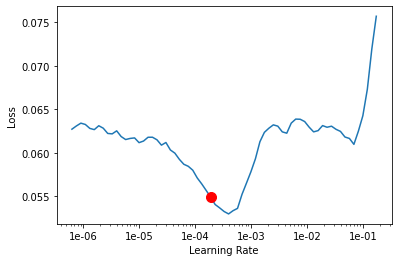

In [63]:
test_1.recorder.plot(suggestion = True)

In [64]:
test_1.fit_one_cycle(100, max_lr = 1.91e-04)

epoch,train_loss,valid_loss,time
0,0.062162,0.058482,00:21
1,0.059379,0.056204,00:21
2,0.055997,0.050679,00:21
3,0.052581,0.045541,00:21
4,0.048808,0.040962,00:21
5,0.045694,0.038026,00:21
6,0.042778,0.036951,00:21
7,0.040737,0.036935,00:21
8,0.039324,0.036576,00:21
9,0.038294,0.035635,00:21


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2506: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


In [0]:
test_1.save('full_res_test1')

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2506: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


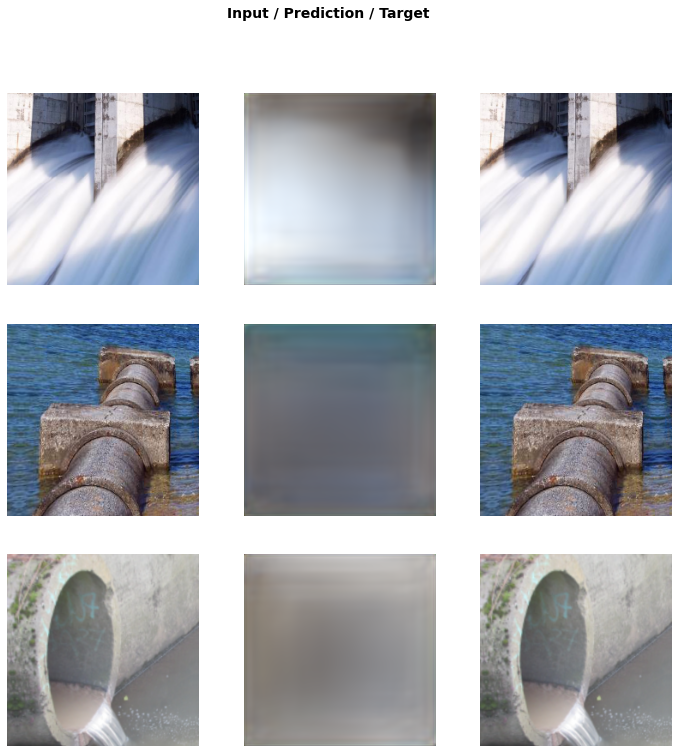

In [66]:
test_1.show_results(ds_type=DatasetType.Train, rows =3)

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2506: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


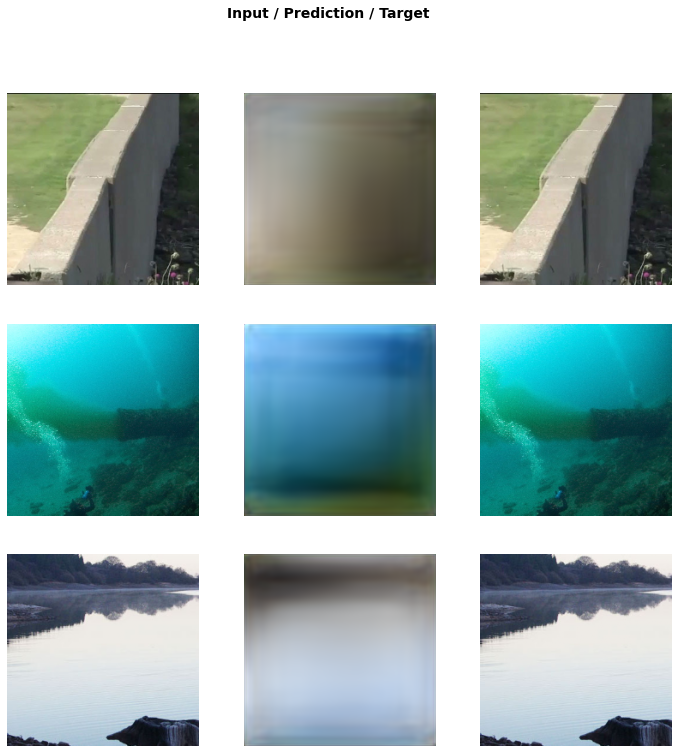

In [67]:
test_1.show_results(ds_type=DatasetType.Valid, rows =3)

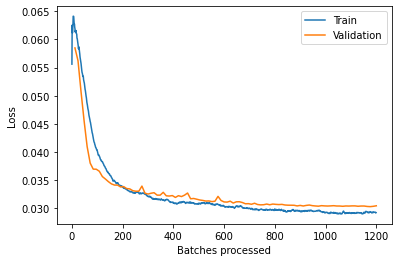

In [68]:
test_1.recorder.plot_losses()

In [0]:
test_1.unfreeze()

In [70]:
test_1.summary()

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2506: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


FullModels
Layer (type)         Output Shape         Param #    Trainable 
Conv2d               [64, 112, 112]       9,408      True      
______________________________________________________________________
BatchNorm2d          [64, 112, 112]       128        True      
______________________________________________________________________
ReLU                 [64, 112, 112]       0          False     
______________________________________________________________________
MaxPool2d            [64, 56, 56]         0          False     
______________________________________________________________________
Conv2d               [64, 56, 56]         36,864     True      
______________________________________________________________________
BatchNorm2d          [64, 56, 56]         128        True      
______________________________________________________________________
ReLU                 [64, 56, 56]         0          False     
___________________________________________________

In [71]:
test_1.lr_find()

epoch,train_loss,valid_loss,time
0,0.028913,#na#,00:17
1,0.028769,#na#,00:17
2,0.028801,#na#,00:16
3,0.028819,#na#,00:17
4,0.029343,#na#,00:17
5,0.037905,#na#,00:16


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2506: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


Min numerical gradient: 1.58E-06
Min loss divided by 10: 2.75E-07


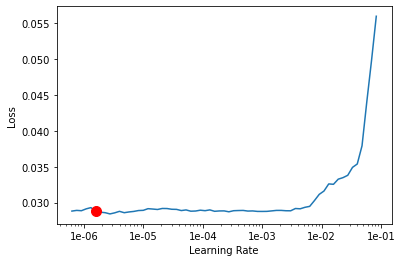

In [72]:
test_1.recorder.plot(suggestion = True)

In [84]:
test_1.fit_one_cycle(100, max_lr = slice(1e-03))

epoch,train_loss,valid_loss,time
0,0.028916,0.032314,00:21
1,0.028842,0.030953,00:21
2,0.028445,0.029237,00:21
3,0.028193,0.028140,00:20
4,0.027926,0.027614,00:21
5,0.027530,0.027181,00:21
6,0.027239,0.028453,00:21
7,0.027129,0.026909,00:20
8,0.026892,0.027066,00:21
9,0.026520,0.030495,00:21


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2506: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


In [0]:
test_1.save('full_res_test2')

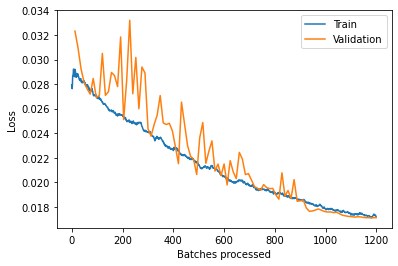

In [85]:
test_1.recorder.plot_losses()

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2506: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


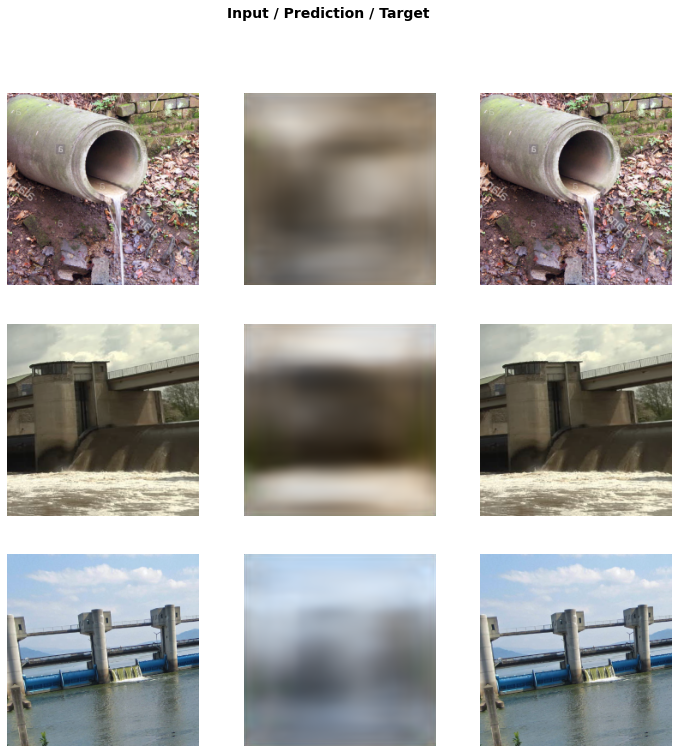

In [86]:
test_1.show_results(ds_type=DatasetType.Train, rows =3)

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2506: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


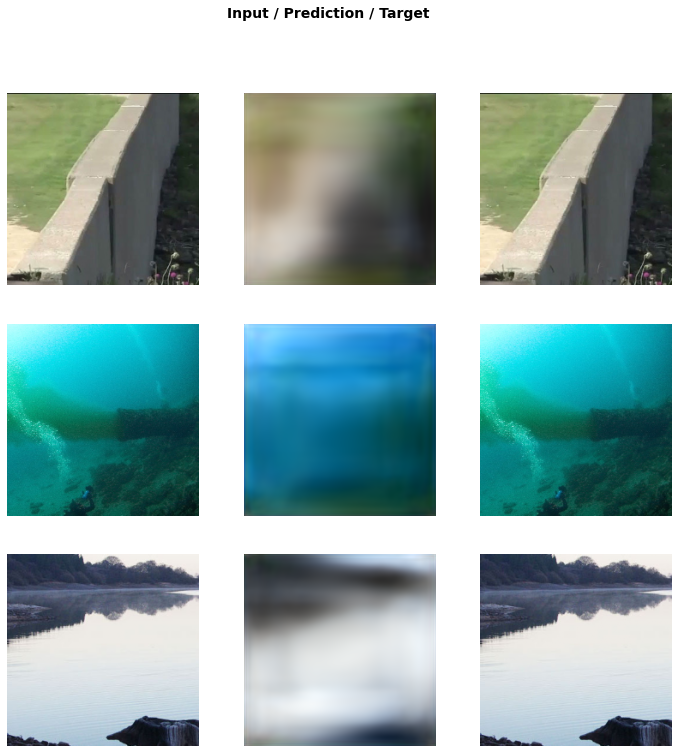

In [87]:
test_1.show_results(ds_type=DatasetType.Valid, rows =3)

In [89]:
test_1.lr_find()

epoch,train_loss,valid_loss,time
0,0.017454,#na#,00:19
1,0.017423,#na#,00:16
2,0.017285,#na#,00:17
3,0.017380,#na#,00:17
4,0.018062,#na#,00:17
5,0.032524,#na#,00:16


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2506: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


Min numerical gradient: 2.29E-06
Min loss divided by 10: 2.51E-06


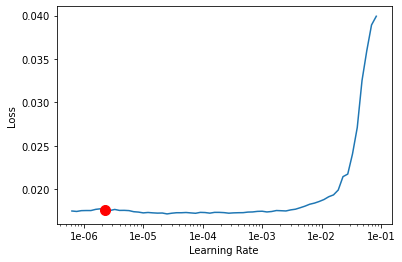

In [91]:
test_1.recorder.plot(suggestion = True)

In [0]:
test_1.fit_one_cycle(20, max_lr = slice(2.29e-06))

epoch,train_loss,valid_loss,time
0,0.017190,0.017127,00:21
1,0.017224,0.017121,00:21
2,0.017429,0.017123,00:21
3,0.017416,0.017119,00:21
4,0.017483,0.017107,00:21
5,0.017411,0.017108,00:21
6,0.017368,0.017136,00:21
7,0.017303,0.017101,00:21
8,0.017276,0.017115,00:21
9,0.017282,0.017132,00:21


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2506: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


In [0]:
test_1.save('full_res_test3')